In [0]:
import os
os.chdir('/content/drive/My Drive/BTP/codes')

In [0]:
import sklearn
from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.svm import SVC
import numpy as np
import pandas as pd 
import cv2
import facial_feature_extraction
import glob
import progressbar
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import srbm
from sklearn.multiclass import OneVsOneClassifier

### Restricted Botzmann Machine

In [0]:
class RbmImpl:
    # constructor
    def __init__(self, num_visible, num_hidden, bool_ver):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.verbose = bool_ver
        np_rng = np.random.RandomState(3412)

        # initialize random weights
        self.weights = np.asarray(np_rng.uniform(
                    low=-4 * np.sqrt(6. / (num_hidden + num_visible)),
                    high=4 * np.sqrt(6. / (num_hidden + num_visible)),
                    size=(num_visible, num_hidden)))

        # add one as first row and first column
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)


    # training code
    def train_rbm(self, data, max_epochs = 2000, learning_rate = 0.08):
        # N = number_samples, D = number_visible_units, H = number_hidden_units
        # data or X is N*D, weights or W is (D+1)*(H+1)
        num_examples = data.shape[0] # sample size
        
        # insert 1 as the first column
        data = np.insert(data, 0, 1, axis = 1) # N * (D+1)
        with progressbar.ProgressBar(max_value=max_epochs) as bar:
            for epoch in range(max_epochs):
                #print(epoch,max_epochs)
                pos_hid_activations = np.dot(data, self.weights) # X * W  ( size = n * (H+1) )
                pos_hid_probs = self.sigmoid(pos_hid_activations) # f(XW) => activation  ( size = n * (H+1) )
                pos_hid_probs[:,0] = 1 # set bias term to one
                pos_hid_states = pos_hid_probs > np.random.rand(num_examples,self.num_hidden + 1) # check great than random weights_(n*H+1)
                pos_associations = np.dot(data.T, pos_hid_probs) # X' * f(XW)  ( size = (D+1)*(H+1) )

                # pos_hid_states back to the visible units
                neg_vis_activations = np.dot(pos_hid_states, self.weights.T) # n * (D+1)
                neg_vis_probs = self.sigmoid(neg_vis_activations) # n * (D+1)
                neg_vis_probs[:,0] = 1 # set bias term to one

                neg_hid_activations = np.dot(neg_vis_probs, self.weights) # n * (H+1)
                neg_hid_probs = self.sigmoid(neg_hid_activations) # n * (H+1)
                neg_associations = np.dot(neg_vis_probs.T, neg_hid_probs) # (D+1) * (H+1)

                # weight updation equation 
                self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples) 

                # calculate L2 error 
                error = np.sum((data - neg_vis_probs) ** 2)
                if self.verbose:
                    print('Epoch '+str(epoch)+' : Error is: '+str(error))
                
                bar.update(epoch)

    #  sigmoid activation function         
    def sigmoid(self, val):
        return 1.0 / (1 + np.exp(-val))

In [0]:
# print bool array
def bool_arr(arr):
  for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
      arr[i,j]=1 if arr[i,j]>=0.5 else 0
  return arr

### Run

In [0]:
def train_util(data):
  rbmInstance = RbmImpl(data.shape[1],100,False)
  rbmInstance.train_rbm(data = data, max_epochs = 100)
  W = rbmInstance.weights
  data = np.insert(data, 0, 1, axis = 1) # add one as first column
  Hid = rbmInstance.sigmoid( np.dot(data,W) ) # n * (H+1)
  Result = Hid[:,1:] # ignore first biased term
  print(".................................................")
  return Result,W

In [0]:
def train_data(path1,path2,total_original,total_retouched):
  print("Extracting facial features from images(original)")
  fp10,fp20,fp30,fp40,fp50,fp60,fp70 = facial_feature_extraction.read_data(path1,total_original)
  print("Extracting facial features from images(retouched)")
  fp11,fp21,fp31,fp41,fp51,fp61,fp71 = facial_feature_extraction.read_data(path2,total_retouched)
  fp1 = np.concatenate((fp10,fp11),axis=0) # n*D1
  fp2 = np.concatenate((fp20,fp21),axis=0) # n*D2
  fp3 = np.concatenate((fp30,fp31),axis=0) # n*D3
  fp4 = np.concatenate((fp40,fp41),axis=0) # n*D4
  fp5 = np.concatenate((fp50,fp51),axis=0) # n*D5
  fp6 = np.concatenate((fp60,fp61),axis=0) # n*D6
  fp7 = np.concatenate((fp70,fp71),axis=0) # n*D7
  a1,W1 = train_util(fp1)
  a2,W2 = train_util(fp2)
  a3,W3 = train_util(fp3)
  a4,W4 = train_util(fp4)
  a5,W5 = train_util(fp5)
  a6,W6 = train_util(fp6)
  a7,W7 = train_util(fp7)
  input_to_svm = np.concatenate((a1,a2,a3,a4,a5,a6,a7),axis=1)
  label_to_SVM = np.concatenate((np.zeros((total_original,1)),np.ones((total_retouched,1))), axis=0) # n*1 
  return input_to_svm,label_to_SVM,W1,W2,W3,W4,W5,W6,W7

In [0]:
def test(path1,path2,total_original,total_retouched):
  label_to_SVM = np.concatenate((np.zeros((total_original,1)),np.ones((total_retouched,1))), axis=0) # n*1 
  # fp : face_patch
  print("Extracting facial features from images(original)")
  fp10,fp20,fp30,fp40,fp50,fp60,fp70 = facial_feature_extraction.read_data(path1,total_original)
  print("Extracting facial features from images(retouched)")
  fp11,fp21,fp31,fp41,fp51,fp61,fp71 = facial_feature_extraction.read_data(path2,total_retouched)
  fp1 = np.concatenate((fp10,fp11),axis=0) # n*D1
  fp2 = np.concatenate((fp20,fp21),axis=0) # n*D2
  fp3 = np.concatenate((fp30,fp31),axis=0) # n*D3
  fp4 = np.concatenate((fp40,fp41),axis=0) # n*D4
  fp5 = np.concatenate((fp50,fp51),axis=0) # n*D5
  fp6 = np.concatenate((fp60,fp61),axis=0) # n*D6
  fp7 = np.concatenate((fp70,fp71),axis=0) # n*D7
  
  return fp1,fp2,fp3,fp4,fp5,fp6,fp7,label_to_SVM

In [0]:
def get_input(path1,path2):
  c1=0
  for file in glob.glob(path1+'*'):
    c1 += 1
  c2=0
  for file in glob.glob(path2+'*'):
    c2 += 1
  X,Y,W1,W2,W3,W4,W5,W6,W7 = train_data(path1,path2,c1,c2)
  return X,Y,W1,W2,W3,W4,W5,W6,W7

In [63]:
path1 = '/content/drive/My Drive/BTP/Dataset/celebrity_dataset/original/' # path to original images
path2 = '/content/drive/My Drive/BTP/Dataset/celebrity_dataset/photoshopped/' # path to retouched images
X,Y,W1,W2,W3,W4,W5,W6,W7 = get_input(path1,path2)
X_train, X_val, y_train, y_val = train_test_split(X, Y.ravel(), test_size=0.2, shuffle=True)

C_reg = [0.1, 0.3, 1, 3, 10, 30, 100, 300]
max_acc = 0
i = 0
save_i = 0
for c in C_reg:
  model = SVC(kernel='rbf', C=c)
  clf = model.fit(X_train,y_train)
  acc = clf.score(X_val,y_val)
  y_pred = clf.predict(X_val)
  if max_acc <= acc:
    max_acc = acc
    save_i = i
  i += 1

Extracting facial features from images(original)


100% (160 of 160) |######################| Elapsed Time: 0:04:26 Time:  0:04:26


done!!!
Extracting facial features from images(retouched)


100% (160 of 160) |######################| Elapsed Time: 0:04:32 Time:  0:04:32
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


done!!!


100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


.................................................


100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


.................................................


100% (100 of 100) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


.................................................


100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


.................................................


100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


.................................................


100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


.................................................


100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


.................................................


classification report

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        40
         1.0       0.76      0.67      0.71        24

    accuracy                           0.80        64
   macro avg       0.79      0.77      0.78        64
weighted avg       0.79      0.80      0.79        64



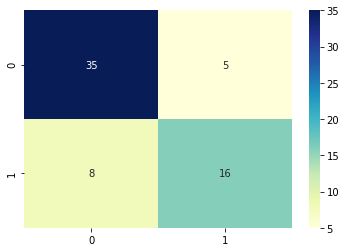

In [78]:
model = SVC(kernel='rbf', C=C_reg[save_i])
# save model
os.chdir('/content/drive/My Drive/BTP/trained_models/')
filename  = 'SVM_FF.sav'
pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open('SVM_FF.sav', 'rb'))
acc = loaded_model.score(X_val,y_val)
y_pred = loaded_model.predict(X_val)
cnf = sns.heatmap(confusion_matrix(y_val, y_pred), cmap="YlGnBu", annot=True)

print("classification report\n")
print(classification_report(y_val,y_pred))